In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
np.random.seed(seed=0)

In [2]:
data = pd.read_csv('../input/amazon-fine-food-reviews/Reviews.csv',
                   nrows=100000)
print('리뷰 개수 :', len(data))

리뷰 개수 : 100000


In [3]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
data = data[['Text', 'Summary']]

In [5]:
data.head()

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy


In [6]:
print('text 에서 중복 뺀 유일한 샘플 수 :', data['Text'].nunique())
print('summary 에서 중복 뺀 유일한 샘플 수:', data['Summary'].nunique())

text 에서 중복 뺀 유일한 샘플 수 : 88426
summary 에서 중복 뺀 유일한 샘플 수: 72348


In [7]:
# text 항목 중복 제거
data.drop_duplicates(subset=['Text'], inplace=True)
print(len(data))

88426


In [8]:
print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


In [10]:
data.dropna(axis=0, inplace=True)
print(len(data))

88425


In [11]:
stop_words = set(stopwords.words('english'))

In [12]:
# 전처리 함수
def preprocess_sentence(sentence, remove_stopwords = True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열  제거 Ex) my husband (and myself) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [13]:
# 전처리 함수 내 사용
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

In [14]:
# data['Text'], data['Summary']
data['Text'].apply(lambda x: preprocess_sentence(x))

0        bought several vitality canned dog food produc...
1        product arrived labeled jumbo salted peanuts p...
2        confection around centuries light pillowy citr...
3        looking secret ingredient robitussin believe f...
4        great taffy great price wide assortment yummy ...
                               ...                        
99995                   love buy another box done last one
99996    late father law used rating system meals parti...
99997    favorite brand korean ramen spicy used eating ...
99998    like noodles although say spicy somewhat under...
99999    love noodle twice week amazing thing feel well...
Name: Text, Length: 88425, dtype: object

In [17]:
clean_summary = []
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, 0))

In [18]:
data['Summary'] = clean_summary

In [19]:
data.replace('', np.nan, inplace=True)

In [21]:
data.dropna(axis = 0, inplace=True)

텍스트의 최소 길이 : 6
텍스트의 최대 길이 : 2520
텍스트의 평균 길이 : 81.38587516269594
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


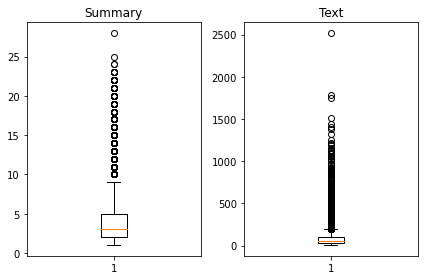

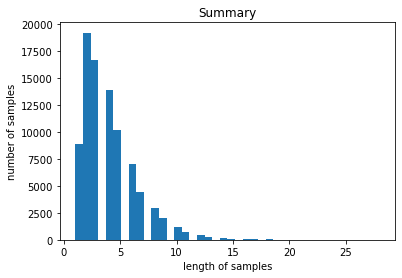

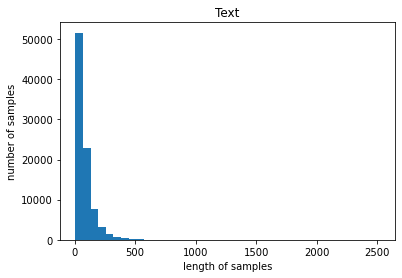

In [22]:
# 길이 분포 출력
text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [35]:
text_max_len = 150
summary_max_len = 8

In [36]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt +=1
            
    print('w전체 샘플 중 길이가 %s 이하인 샘플 비율 : %s' %(max_len, (cnt/len(nested_list))))

In [37]:
below_threshold_len(text_max_len, data['Text'])

w전체 샘플 중 길이가 150 이하인 샘플 비율 : 0.8806519155678796


In [38]:
below_threshold_len(summary_max_len, data['Summary'])

w전체 샘플 중 길이가 8 이하인 샘플 비율 : 0.9424593967517402


In [39]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]

In [40]:
data.head()

,Text,Summary
0,I have bought several of the Vitality canned d...,good quality dog food
1,Product arrived labeled as Jumbo Salted Peanut...,not as advertised
2,This is a confection that has been around a fe...,delight says it all
3,If you are looking for the secret ingredient i...,cough medicine
4,Great taffy at a great price. There was a wid...,great taffy


In [41]:
print(len(data))

74378


In [43]:
data['decoder_input'] = data['Summary'].apply(lambda x : '<sos>' + x)
data['decoder_target'] = data['Summary'].apply(lambda x: x + '<eos>')
data.head()

,Text,Summary,decoder_input,decoder_target
0,I have bought several of the Vitality canned d...,good quality dog food,<sos>good quality dog food,good quality dog food<eos>
1,Product arrived labeled as Jumbo Salted Peanut...,not as advertised,<sos>not as advertised,not as advertised<eos>
2,This is a confection that has been around a fe...,delight says it all,<sos>delight says it all,delight says it all<eos>
3,If you are looking for the secret ingredient i...,cough medicine,<sos>cough medicine,cough medicine<eos>
4,Great taffy at a great price. There was a wid...,great taffy,<sos>great taffy,great taffy<eos>


In [44]:
encoder_input = np.array(data['Text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

In [45]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

In [46]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [47]:
n_val = int(len(encoder_input) * 0.2)

In [48]:
encoder_input_train = encoder_input[:-n_val]
decoder_input_train = decoder_input[:-n_val]
decoder_target_train = decoder_target[:-n_val]

In [49]:
encoder_input_test = encoder_input[-n_val:]
decoder_input_test = decoder_input[-n_val:]
decoder_target_test = decoder_target[-n_val:]

In [51]:
print(len(encoder_input_train), len(decoder_input_train), len(encoder_input_test), len(decoder_input_test))

59503 59503 14875 14875


In [52]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(encoder_input_train)

In [53]:
tokenizer.word_index

{'the': 1,
 'i': 2,
 'and': 3,
 'a': 4,
 'it': 5,
 'to': 6,
 'is': 7,
 'this': 8,
 'of': 9,
 'for': 10,
 'in': 11,
 'my': 12,
 'br': 13,
 'but': 14,
 'that': 15,
 'have': 16,
 'not': 17,
 'with': 18,
 'are': 19,
 'was': 20,
 'you': 21,
 'they': 22,
 'like': 23,
 'these': 24,
 'as': 25,
 'on': 26,
 'so': 27,
 'them': 28,
 'good': 29,
 'great': 30,
 'taste': 31,
 'very': 32,
 'be': 33,
 'product': 34,
 'at': 35,
 'just': 36,
 'one': 37,
 'flavor': 38,
 'or': 39,
 'all': 40,
 'if': 41,
 'coffee': 42,
 'love': 43,
 "it's": 44,
 'we': 45,
 'from': 46,
 'can': 47,
 'tea': 48,
 'when': 49,
 'will': 50,
 'has': 51,
 'more': 52,
 'had': 53,
 'would': 54,
 'me': 55,
 'than': 56,
 'no': 57,
 'get': 58,
 'really': 59,
 'other': 60,
 'out': 61,
 'amazon': 62,
 'too': 63,
 'food': 64,
 'only': 65,
 'some': 66,
 'up': 67,
 'much': 68,
 'price': 69,
 'about': 70,
 'best': 71,
 'buy': 72,
 'were': 73,
 "don't": 74,
 'little': 75,
 'time': 76,
 'use': 77,
 'an': 78,
 'tried': 79,
 'because': 80,
 'also'

In [54]:
threshold = 7
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

In [55]:
for k, v in tokenizer.word_counts.items():
    total_freq += v
    
    if v < threshold:
        rare_cnt += 1
        rare_freq += v

In [56]:
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 40602
등장 빈도가 6번 이하인 희귀 단어의 수: 30132
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10470
단어 집합에서 희귀 단어의 비율: 74.21309295108615
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.5357577039697052


In [57]:
src_vocab = 8000
tokenizer = Tokenizer(num_words=src_vocab)
tokenizer.fit_on_texts(encoder_input_train)

In [58]:
encoder_input_train = tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = tokenizer.texts_to_sequences(encoder_input_test)

In [59]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [60]:
threshold = 7
total_cnt = len(tar_tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

In [61]:
for k, v in tar_tokenizer.word_counts.items():
    total_freq += v
    
    if v < threshold:
        rare_cnt += 1
        rare_freq += v

In [62]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [63]:
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

In [64]:
drop_train = [idx for idx, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [idx for idx, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

In [65]:
encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

In [66]:
encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

In [68]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

In [69]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [70]:
embedding_dim = 128
hidden_size = 256

In [71]:
encoder_inputs = Input(shape=(text_max_len,))

In [72]:
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

In [75]:
# LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True,
                     dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

In [77]:
# LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True,
                     dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

In [78]:
# LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True,
                     dropout=0.4, recurrent_dropout=0.4)
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

In [79]:
# decoder

decoder_inputs = Input(shape=(None,))

# emb
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

In [80]:
decoder_lstm = LSTM(hidden_size, return_sequences=True, 
                    return_state=True, dropout=0.4, recurrent_dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3])

In [81]:
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

In [82]:
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)

In [83]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [86]:
attn_layer = AttentionLayer(name='attention')
attn_out, attn_states = attn_layer([encoder_output3, decoder_outputs])

In [87]:
# attention 결과와 디코더의 hidden state concat
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

In [88]:
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

In [89]:
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)

In [90]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [91]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [ ]:
history = model.fit(x = [encoder_input_train, decoder_input_train], 
                   y = decoder_target_train,
                    validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
                    batch_size = 256, callbacks=[es], epochs=50
                   )

Epoch 1/50
227/227 [==============================] - 408s 2s/step - loss: 2.7302 - val_loss: 2.4631
Epoch 2/50
227/227 [==============================] - 398s 2s/step - loss: 2.4124 - val_loss: 2.3342
Epoch 3/50
146/227 [==================>...........] - ETA: 2:19 - loss: 2.2983

In [ ]:
# 모델 테스트

In [ ]:
src_idx_to_word = tokenizer.index_word
tar_word_to_idx = tar_tokenizer.word_index
tar_idx_to_word = tar_tokenizer.index_word

In [ ]:
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_output3, state_h3, state_c3])

In [ ]:
# 이전 시점의 상태를 저장
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

In [ ]:
dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h,
                                                                            decoder_state_input_c])

In [ ]:
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis = -1, name='concat')([decoder_outputs2, attn_out_inf])

decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2]
)

In [ ]:
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_idx['<sos>']
    
    stop_condtion = False
    decoded_sentence = ''
    
    while not stop_condition:
        
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_idx = np.argmax(output_tokens[0, -1 :])
        sampled_token = tar_idx_to_word[sampled_token_idx]
        
        if sampled_token = '<eos>':
            decoded_sentence += ' ' + sampled_token
            
        if sampled_token == '<eos>' or len(decoded_sentence.split()) >= summary_max_len -1:
            stop_condition = True
            
        target_seq = np.zeros((1,1))
        target_seq[0,0] = sampled_token_idx
        
        e_h, e_c = h, c
        
    return decoded_sentence

In [ ]:
def seq2text(input_seq):
    tmp = ''
    for i in input_seq:
        if i != 0:
            tmp += src_idx_to_word[i] + ' '
    return tmp

In [ ]:
def seq2summary(input_seq):
    tmp = ''
    for i in input_seq:
        if i != 0and i != tar_word_to_idx['<sos>'] and i != tar_word_idx['<eos>']:
            tmp += tar_idx_to_word[i] + ' '
            
    return tmp

In [ ]:
for i in range(500, 1000):
    print("원문 : ",seq2text(encoder_input_test[i]))
    print("실제 요약문 :",seq2summary(decoder_input_test[i]))
    print("예측 요약문 :",decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

In [ ]:
원문 : great product husband eat kind price could little lower even like jerky eater 
실제 요약문 : best jerky there is 
예측 요약문: great jerky

원문 : perfect stress free afternoon aroma tea makes house smell great drink grade honey bliss 
실제 요약문 : relax cup of tea 
예측 요약문: great tea

원문 : dog loves stuff ground sprinkled dry food gobbles additives fillers carbs also use treat best price amazon quick delivery 
실제 요약문 : great 
예측 요약문: great dog food

원문 : got bbq popchips amazon promotion price came taste good wish less salty would certainly purchase came less salty version 
실제 요약문 : tasty but wish it was less salty 
예측 요약문 : not the best

원문 : product arrived broken pieces flavor good actually threw garbage disappointing 
실제 요약문 : very disappointed 
예측 요약문: not as described

원문 : buying quaker oats granola bars nature valley chewy bars better tasting make great snack go chocolate peanuts raisins get better 
실제 요약문 : my new granola bar 
예측 요약문: great snack

원문 : yuck worst chocolate ever save money brand find another even taste taste like chocolate threw rest away 
실제 요약문 : horrible chocolate 
예측 요약문 : awful

원문 : kit great rd kit made easy follow instructions new making wines really good kit learn product quite tasty good tropical fruit wine purchased store get idea would making like better store bought one 
실제 요약문 : the kit is great 
예측 요약문 : great for cooking

원문 : son particularly picky eater occasionally gets fussy matter mood great meal option fall back always eat also pouch sturdy makes good travel meal option little expensive worth every penny 
실제 요약문 : my son loves these 
예측 요약문 : great for baby food

원문 : labeled green tea touch pomegranate raspberry essence might rated higher however name pomegranate raspberry therefore expected vary flavors overall taste mild except greater sweetness tea second ingredient chamomile distinctive presence find flavor unpleasant nothing would make reach one teas 
실제 요약문 : the flavor was not what expected 
예측 요약문 : not for me

원문 : delighted food looks nice smells really great smaller size kibble old dog teeth comes ziplock pouch importantly though old dog getting little suddenly gotten since starting chow also noticed terrible daily gone fair time switched wet food harmony foods may also factor extremely happy food continue buy 
실제 요약문 : highly recommend this 
예측 요약문 : my dog loves this
